**미니프로젝트의 목표!**
- Objective 1: 직접 ARIMA를 통해 시계열 예측을 수행해보자!
- Objective 2: 직접 ARCH를 통해 S&P500의 변동성을 모델링하자!

**루브릭**
1. AirPassengers 데이터셋을 통해 전처리 과정을 체계적으로 진행하였다.     
각 학습 단계별 전처리 과정 중 로그 변환 및 차분 분석을 통해 ACF, PACF plot을 시각화하고 결과값이 제대로 출력되었는지 확인하였다.    

2. AutoARIMA의 적용 및 결과를 확인하였는가?     
AutoARIMA를 실행하여 Best model 결과를 확인하고 ARIMA 수식에서 나오는 p,d,q 및 지표의 AIC, Time을 통해 선정 이유를 분석해본다.     

3. ARCH 모델이 제대로 작동하는지 확인하고 결과를 분석했는가?     
데이터를 ARCH 모델에 적합하고 나온 지표와 시각화된 결과를 통해 어떤 유의미한 결과를 얻었는지 설명할 수 있다.

# Air Passenger로 ARIMA 실습
## ① 데이터 연결하기

In [1]:
# 먼저 데이터가 저장된 폴더를 연결합시다.
!mkdir -p aiffel/time_series_basic
#!ln -s data/* aiffel/time_series_basic
!cp ../../data/AirPassengers.csv aiffel/time_series_basic/

cp: cannot stat '../../data/AirPassengers.csv': No such file or directory


In [2]:
!pip install arch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.0/908.0 KB 13.9 MB/s eta 0:00:00a 0:00:01


## ② ARIMA 실습해보기!
앞에서도 자주 만났던 AirPassengers 데이터셋을 SARIMA를 통해 예측해봅시다.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf #acf plot 및 pacf plot을 그리기 위한 라이브러리
from statsmodels.tsa.arima_model import ARIMA #아리마 모델
import pmdarima as pm #오토 아리마

In [4]:
ap = pd.read_csv('/aiffel/aiffel/time_series_basic/AirPassengers.csv')
ap.drop('Month', axis = 1, inplace = True)

## ③ 데이터 확인하기

In [5]:
ap

,#Passengers
0,112
1,118
2,132
3,129
4,121
...,...
139,606
140,508
141,461
142,390


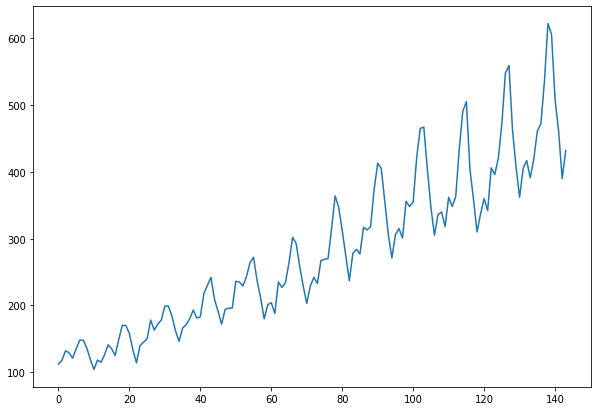

In [6]:
plt.figure(figsize=(10,7))
plt.plot(ap)
plt.show()

## ④ 분산을 일정하게 만들기 - log transformation
Log Transformation을 통해 variance를 일정하게 조절

In [7]:
# np.log를 통해서 log transformation
ap_transformed = np.log(ap)

In [8]:
ap_transformed

,#Passengers
0,4.718499
1,4.770685
2,4.882802
3,4.859812
4,4.795791
...,...
139,6.406880
140,6.230481
141,6.133398
142,5.966147


[]

<Figure size 936x432 with 0 Axes>

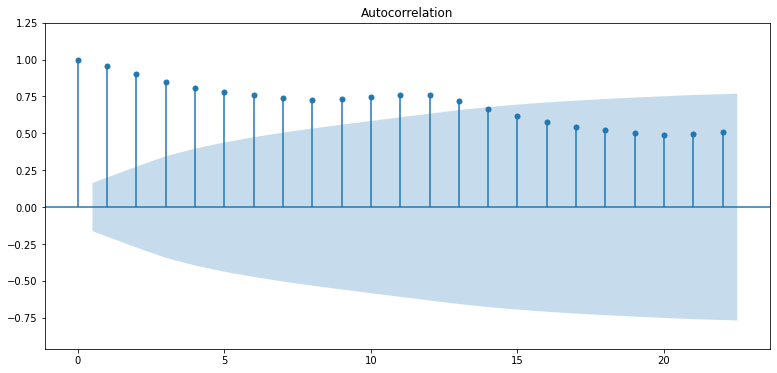

In [17]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6   
plt.figure()
plot_acf(ap_transformed, auto_ylims= True) #acf plot, 점차 감소하는 모양새를 지니고 있음
plt.plot()

#### ACF에서는 1~13이 유의미한 값을 가지며 그 중 1이 가장 영향이 크다. 그러나 그래프가 전체적으로 완만하게 줄어드는 형태라 q=0으로 둘 수 있다. 


[]

<Figure size 936x432 with 0 Axes>

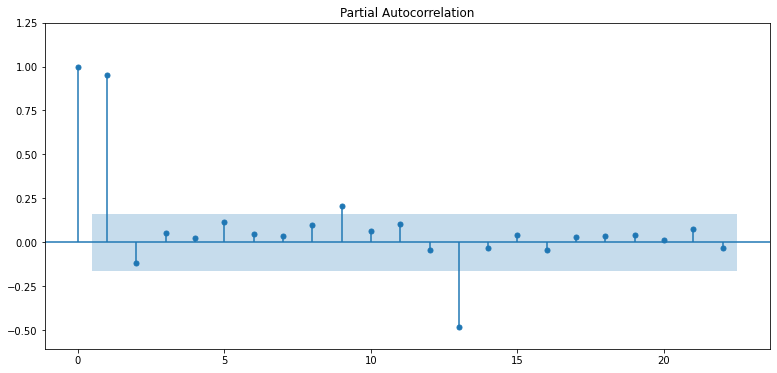

In [34]:
plt.figure()
plot_pacf(ap_transformed, auto_ylims= True, method='ywm') #pacf plot, lag 2까지 유의미한 결과를 보임
plt.plot()

#### PACF에서는 1, 9, 13에서 유의미한 값을 보이며, p=1이 적합한듯 보인다. 
#### ywm warnings 경고가 나오며, 그래프의 사이즈도 바뀌지 않는다. 구글링을 해봐도 해결 방법을 못 찾겠다. 경고 메세지에 method='ywm'를 사용하라고 나와 적용했다. 경고는 사라졌지만, 그래프 사이즈는 바뀌지 않는다. 
#### 그래프 사이즈는 rcParams로 바꿔주었다. 

## ⑤ 차분을 통해 분석하기
추세가 있는 데이터라서 위와 같은 형태를 띰

In [19]:
ap_diff = ap_transformed.diff()
ap_diff = ap_diff.dropna()

[]

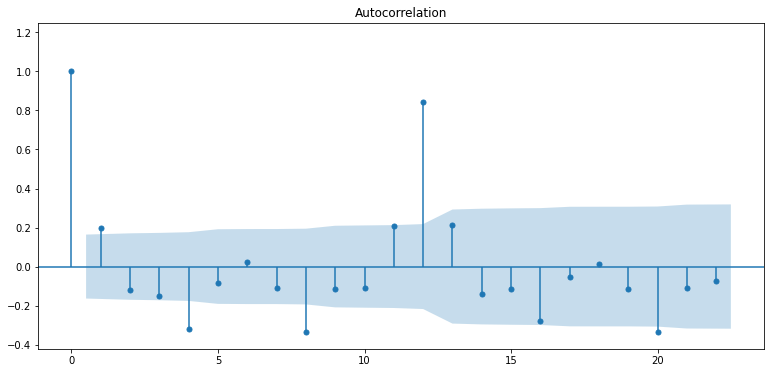

In [21]:
# lag 1과 lag 12에서 유의미한 lag가 포착됨
plot_acf(ap_diff, auto_ylims= True)
plt.plot()

#### 파란색 음영을 간신히 넘어가는건 검증이 필요하다. 그러나 12는 유의미하다.  

[]

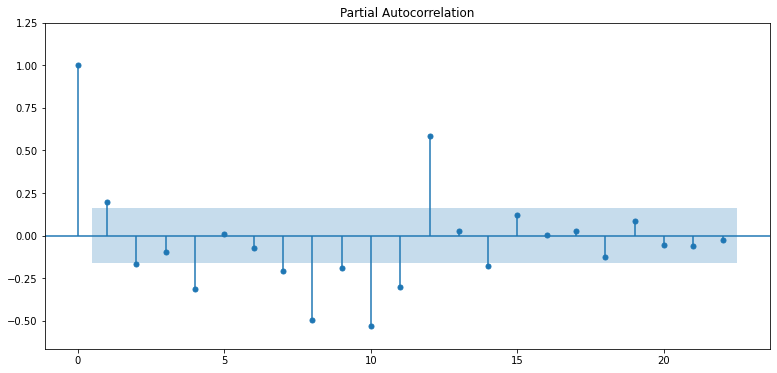

In [22]:
#lag 1, lag 8~12쯤에서 유의미한 lag가 포착됨
plot_pacf(ap_diff, auto_ylims= True, method='ywm')
plt.plot()

#### ACF, PACF 공통적으로 lag 12에서 유의미한 결과를 보인다. 이는 계절성 성분일 수도 있기 때문에 auto-arima에서 계절성을 고려하도록 SARIMA를 켜줘야한다.  그러나 auto-arima가 이를 유의미하다고 보지 않으면 그게 맞을 수도 있다.  
#### 위에서 PACF 분석할 때와 같은 ywm 경고가 나와 method='ywm'을 추가해주었다. 

In [23]:
ap_transformed

,#Passengers
0,4.718499
1,4.770685
2,4.882802
3,4.859812
4,4.795791
...,...
139,6.406880
140,6.230481
141,6.133398
142,5.966147


In [24]:
train_size = int(len(ap_transformed)*0.8)

ap_transformed_train = ap_transformed[:train_size]
ap_transformed_test = ap_transformed[train_size:]

## ⑥ Auto ARIMA 적용
auto arima로 모델을 적합해보자

In [27]:
model = pm.AutoARIMA(seasonal = True, suppress_warnings = True, trace = True, max_D = 12) #seasonal = True 체크, # 계절차분(D) = 12
res = model.fit(ap_transformed_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.61 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-189.733, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-191.035, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-192.641, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-189.957, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-196.702, Time=0.21 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.61 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.69 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-196.895, Time=0.21 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.64 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.64 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-196.569, Time=0.10 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 4.002 seconds


#### seasonal = True로 계절성을 열어주었다.  AIC=inf가 나오면 정말 안 맞는 파라미터이다. 
#### (0, 1, 2)가 가장 적합하다고 나왔다. 위에서 ACF, PACF 그래프를 통해 p=1, q=0이 적합할 것이라고 예상했는데, 실제 Auto-Arima가 추천한 것과 다름을 확인할 수 있다. 

In [29]:
#confidence interval까지 도출
preds, conf_int = res.predict(n_periods=ap_transformed_test.shape[0], return_conf_int=True) 

print(preds.shape) 
print(type(preds))
print('--'*40)
print(preds.shape[0])
print(type(preds.shape[0]))
print('--'*40)
print(preds)
print('--'*40)
print(conf_int)

(29,)
<class 'numpy.ndarray'>
--------------------------------------------------------------------------------
29
<class 'int'>
--------------------------------------------------------------------------------
[6.18010083 6.14616332 6.15817888 6.17019443 6.18220998 6.19422554
 6.20624109 6.21825665 6.2302722  6.24228775 6.25430331 6.26631886
 6.27833442 6.29034997 6.30236553 6.31438108 6.32639663 6.33841219
 6.35042774 6.3624433  6.37445885 6.3864744  6.39848996 6.41050551
 6.42252107 6.43453662 6.44655218 6.45856773 6.47058328]
--------------------------------------------------------------------------------
[[5.98736259 6.37283907]
 [5.85107277 6.44125387]
 [5.82729445 6.48906331]
 [5.807027   6.53336186]
 [5.78940386 6.57501611]
 [5.77386531 6.61458577]
 [5.760025   6.65245718]
 [5.74760298 6.68891031]
 [5.73638867 6.72415573]
 [5.72621895 6.75835656]
 [5.71696441 6.7916422 ]
 [5.70852037 6.82411736]
 [5.70080067 6.85586817]
 [5.69373342 6.88696652]
 [5.68725791 6.91747314]
 [5.681322

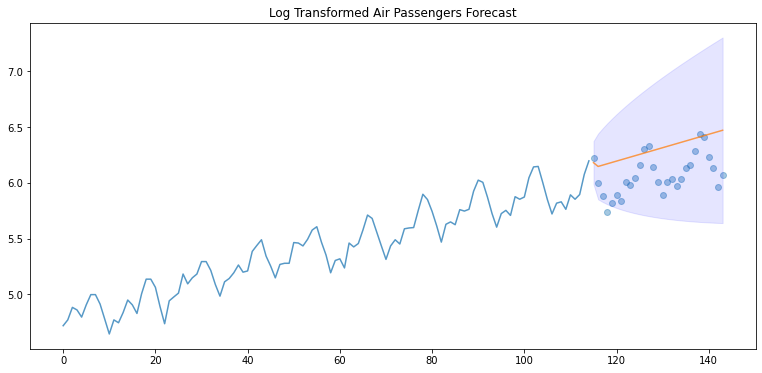

In [30]:
# 예측 성능을 시각화합니다. 
# 0. train과 test data를 축(axis)으로 만들었습니다.
# 1. x축은 test으로 만들어 놓은 train data를 사용하고, y축에 train data를 사용하여 train data를 시각화 합니다.
# 2. 1번 그래프에서 정답(AutoARIMA를 통해 만든 예측 값)에 해당하는 일자형 그래프가 생성됩니다.
# 3. 원래 가지고 있던 데이터셋의 y값(지도 학습의 정답)을 산점도(scatter plot)로 생성합니다.
# 4. 2, 3번의 분포에 해당하는 구간을 채워 그래프로 나타냈습니다.
x_axis = np.arange(ap_transformed_train.shape[0] + preds.shape[0]) # 115 + 29, plot을 그리기 위해 x축을 생성합니다. # 0
plt.plot(x_axis[:ap_transformed_train.shape[0]],ap_transformed_train, alpha=0.75) # 1
plt.plot(x_axis[ap_transformed_train.shape[0]:], preds, alpha=0.75) # 2
plt.scatter(x_axis[ap_transformed_train.shape[0]:],ap_transformed_test, 
            alpha=0.4, marker='o')  # 3 기존 test data는 scatter
plt.fill_between(x_axis[-preds.shape[0]:],
                 conf_int[:, 0], conf_int[:, 1],
                 alpha=0.1, color='b') # 4
plt.title("Log Transformed Air Passengers Forecast") # plot의 제목
plt.show() # 4개의 plot을 시각화 합니다.

#### x=120까지는 train data, 120 이상에서 scatter는 원래의 정답, 주황색 선은 ARIMA 모델이 예측한 점추정, 음영은 95% 신뢰구간으로 구간추정한 것이다. 
#### 실제 y값들이 대부분 추정된 구간 안에 들어가있음을 확인할 수 있다.

# S&P 500으로 ARCH 실습

## ⑦ ARCH 모델 실습해보기

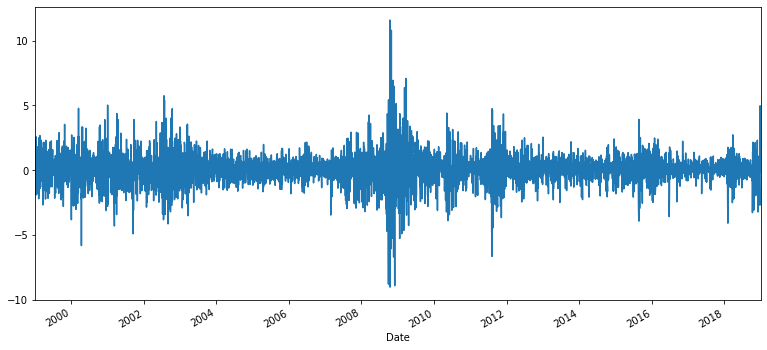

In [31]:
# ⑦-1 : 데이터 및 라이브러리 불러오기
import datetime as dt # 날짜와 시간을 조작할 수 있는 Python 라이브러리 입니다.
import arch.data.sp500 # S&P 500 데이터셋을 arch에서 불러옵니다.

# ⑦-2 : 필요한 데이터로 가공하고 시각화를 통해 확인하기
st = dt.datetime(2002, 1, 1) #start date
en = dt.datetime(2022, 1, 1) #end date
data = arch.data.sp500.load() #s&p 500 데이터 불러오기
market = data["Adj Close"] #종가만 활용
returns = 100 * market.pct_change().dropna() #return값으로 변환
ax = returns.plot() # 수익률을 그래프로 만들기
xlim = ax.set_xlim(returns.index.min(), returns.index.max()) # xlim은 x축 값의 보기를 제한 합니다. 
plt.show()

#### 라이브러리에서 데이터를 불러와 날짜를 2002년 1월 1일에서 2022년 1월 1일로 설정한 코드이다. 
#### 여러 cluster가 있는 것으로 보아, 조건부 이분산성(Conditional Heteroskedasticity)이 이 데이터에 나타남을 확인할 수 있다. 

In [32]:
# ⑦-3 : ARCH 모델 적용
from arch import arch_model

am = arch_model(returns) #return을 arch모델에 적합
res = am.fit(update_freq=5)

# ⑦-4 : 지표를 통한 결과 확인
print(res.summary())
#다양한 결과가 제시되어있으나, 수업때 배웠던 p-value, AIC, BIC위주로 내용을 파악
#아래에 있는 volatility model을 보면 alpha[1], Beta[1]은 GARCH(1,1)을 의미하며, p-value를 통해 신뢰도 99%에서 이들이 유의미함을 도출

Iteration:      5,   Func. Count:     35,   Neg. LLF: 6970.2765831170655
Iteration:     10,   Func. Count:     63,   Neg. LLF: 6936.718477482658
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6936.718476988985
            Iterations: 11
            Function evaluations: 68
            Gradient evaluations: 11
                     Constant Mean - GARCH Model Results                      
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -6936.72
Distribution:                  Normal   AIC:                           13881.4
Method:            Maximum Likelihood   BIC:                           13907.5
                                        No. Observations:                 5030
Date:                Thu, Jan 05 2023   Df Residuals:                     5029
Time:         

#### AIC, BIC는 낮을수록 모델의 적합도가 높다. 
#### Volatility Model의 alpha[1], beta[1]에서 p-value가 매우 작은 것을 확인할 수 있다. 
- alpha = ARCH 모델을 통해 얻을 수 있는 파라미터    
- beta = GARCH 모델에서만 나타나는 파라미터

#### 따라서 GARCH(1,1) 모델에 적합되는 것을 확인할 수 있다. 

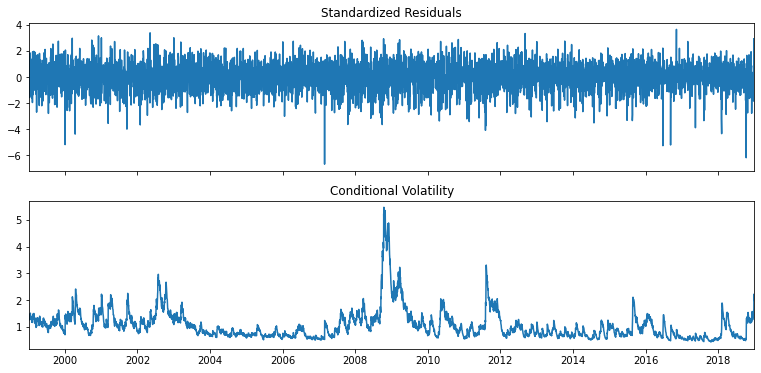

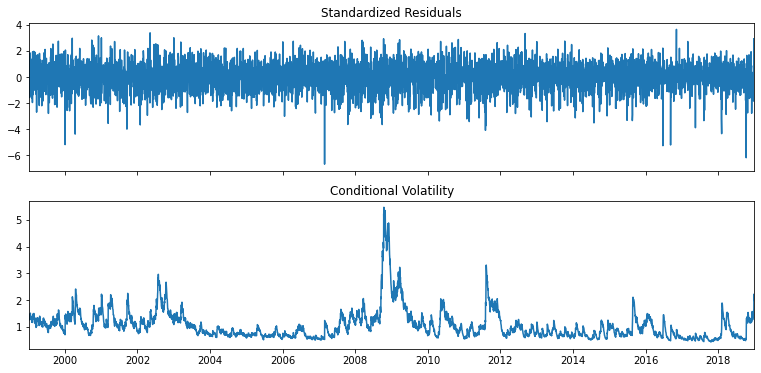

In [33]:
# ⑦-5 : 시각화를 통한 결과값 확인
res.plot()

#### 모델 적합 후 남은 Residual에 뚜렷한 이분산성이 없는 것으로 보아, 모델 적합이 잘 되었음을 확인할 수 있다. 


## 회고

#### 헤맸던 것
- 이전에 했던 미니프로젝트들과 전체적으로 유사한 과정이라, 크게 시간을 허비하며 헤맨 내용은 없다.
- PACF 그래프에서만 ywm warnings 경고가 나왔다. 
- ACF, PACF 그래프는 figsize로 크기를 조절할 수 없다. 

#### 새롭게 알게된 것
- 예측 성능 시각화시 구간을 표현하면 훨씬 이해하기 좋은 그래프가 된다. 
-  ywm warnings 경고 메세지에 나온대로, 코드에 method='ywm'를 넣으면 해결할 수 있다.  
- figsize로 크기가 조절되지않을 땐 rcParams를 사용한다. 
- ARCH 모델에서 alpha, beta의 의미를 알게되었다. 

#### 아직도 모르는 것
- preds와 conf_int 출력한 내용을 어떻게 활용할지 모르겠다. 
- 차분을 한 상태에서 ACF, PACF 그래프를 그렸을 때 나오는 유의미한 lag를 p, q 값으로 정하고, 차분을 했으므로 d=1로 정하면 되나? 잘 모르겠다.  
- 마지막에 그린 Conditional Volatility 그래프를 어떻게 파악해야할지 모르겠다. 